# Creating a single-asset portfolio, then attempting to hedge the portfolio value and minimize variance using futures contracts

In [2]:
# Installing dependencies

import pandas as pd
import numpy as np
!pip install --upgrade yfinance
import yfinance as yf
import statsmodels.api as sm

In [3]:
# Collecting Historical data for SPDR S&P 500 Index ETF and CME S&P 500 E-mini Futures

from curl_cffi import requests
session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('...', session=session)

start_date = '2020-01-01'
end_date = '2024-12-31'

try:
    spy_futures = yf.download('ES=F', start = start_date, end = end_date)
    spy_etf = yf.download('SPY', start = start_date, end = end_date)
    
except Exception as e:
    print(e)

C:\Users\ishow\AppData\Local\Temp\ipykernel_19168\4023084919.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_futures = yf.download('ES=F', start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ishow\AppData\Local\Temp\ipykernel_19168\4023084919.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_etf = yf.download('SPY', start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed


In [4]:
cols_to_drop = ['High', 'Low', 'Open', 'Volume']

spy_futures  = spy_futures.drop(columns=cols_to_drop)
spy_etf = spy_etf.drop(columns=cols_to_drop)

# Calculate daily price changes for the ETF and Futures

futures_df = spy_futures['Close'].pct_change().dropna() * 100
etf_df = spy_etf['Close'].pct_change().dropna() * 100

In [5]:
merged_df = futures_df.join(etf_df, how='inner')
merged_df

Ticker,ES=F,SPY
Date,,
2020-01-03,-0.721080,-0.757240
2020-01-06,0.247257,0.381493
2020-01-07,-0.254355,-0.281139
2020-01-08,0.772738,0.532946
2020-01-09,0.483092,0.678055
...,...,...
2024-12-23,3.351567,0.598837
2024-12-24,1.027170,1.111498
2024-12-26,-0.045097,0.006656


## Running a simple linear Regression by regressing the daily changes in the ETF price against the daily changes in the corresponding futures contract price

## But before that, I will split my data into 5 different time periods, as different calendar years have different economic 'regimes'. Of course, I acknowledge that splitting on the basis of calendar year is a simplification and may not necessarily capture the different regimes that existed at the time

In [7]:
# Taking the futures price changes, X, as the input variable, and the ETF price changes, y, as the output variable, I will split the data in 5 different
# time periods: 2020, 2021, 2022, 2023, 2024

regression_variables = {}

for i in range(5):
    regression_variables[f'X_202{i}'] = np.array(merged_df.loc[f'202{i}-01-01':f'202{i}-12-31', 'ES=F'])
    regression_variables[f'y_202{i}'] = np.array(merged_df.loc[f'202{i}-01-01':f'202{i}-12-31', 'SPY'])

print(regression_variables['X_2024'])

[-0.67946058 -0.85121938 -0.35815864  0.11100539  1.40450921 -0.17703723
  0.57378332 -0.09854261  0.02076628 -0.37371535 -0.5678858   0.83835473
  1.21070408  0.23616388  0.28682647  0.06128703  0.51551654 -0.1421825
  0.77803204 -0.07064285 -1.62593415  1.19084283  1.05001522 -0.36644747
  0.25695284  0.81411126  0.04984796  0.52314284 -0.05452022 -1.38854451
  0.94040734  0.56795536 -0.53007035 -0.56277703  0.09516178  2.03152364
  0.07356187 -0.41654415  0.19191969 -0.17681729  0.44774651  0.82782268
 -0.15060241 -1.02174865  0.51123236  0.9781386  -0.63447474 -0.11698187
  1.05894983 -0.17866628 -0.27573529 -1.01052783  2.21653066  0.51776212
  0.85849192  0.2979146  -0.17444602 -0.28337978 -0.24629375  0.81667537
  0.00470965 -0.2495997  -0.65624852  0.1140576  -1.31491503  1.07268267
  0.00475919  0.13325084 -0.99805142  0.68167635 -1.44471463 -1.22883406
 -0.22531348 -0.5940108  -0.26174132 -0.89621707  0.87434424  1.16889549
  0.01958288 -0.49437102  0.96905898  0.30205593 -1.

In [8]:
# Using statsmodel to fit Linear Regression model for all time periods

regression_models = {}

for i in range(5):
    X = sm.add_constant(regression_variables[f'X_202{i}'])
    y = regression_variables[f'y_202{i}']
    regression_models[f'model_202{i}'] = sm.OLS(y, X).fit()

regression_models['model_2024'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     2431.
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          1.76e-130
Time:                        14:22:53   Log-Likelihood:                0.82505
No. Observations:                 251   AIC:                             2.350
Df Residuals:                     249   BIC:                             9.401
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0135      0.015      0.879      0.380      -0.017       0.044
x1             0.9053      0.018     49.306      0.000       0.869       0.941
==============================================================================
Omnibus:                      287.454   Durbin-Watson:                   2.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32724.985
Skew:                          -4.391   Prob(JB):                         0.00
Kurtosis:                      58.245   Cond. No.                         1.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# Extract the slope coefficients and store them. After, compute the average of the Betas, which will them become my optimal
# hedge ratio, h*

model_betas = []

for key, value in regression_models.items():
    model_betas.append(value.params[1])

mvhr = np.mean(model_betas)

print(model_betas)
print(mvhr)

[0.9404856472489936, 0.9865039674277665, 1.0046485955225284, 0.9805739985693951, 0.9052618645093138]
0.9634948146555995


## Time to now backtest two portfolios: an unhedged one, and a hedged one. In the hedged portfolio, I will hedge my exposure in my single asset portfolio consisting of the SPY ETF using E-mini futures contract, applying the calculated minimum variance hedge ratio, h*

## I will assume an initial portfolio value of 100,000, and then plot portfolio value over the year 2025 (up until the date I conducted the backtest), comparing and assessing various portfolio statistics

In [11]:
start_date = '2025-01-01'
end_date = '2025-10-14'

try:
    test_spy_futures = yf.download('ES=F', start = start_date, end = end_date)
    test_spy_etf = yf.download('SPY', start = start_date, end = end_date)
    
except Exception as e:
    print(e)

test_spy_futures

C:\Users\ishow\AppData\Local\Temp\ipykernel_19168\2090975350.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_spy_futures = yf.download('ES=F', start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ishow\AppData\Local\Temp\ipykernel_19168\2090975350.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_spy_etf = yf.download('SPY', start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,ES=F,ES=F,ES=F,ES=F,ES=F
Date,,,,,
2025-01-02,5916.50,5995.25,5874.75,5949.25,1826031
2025-01-03,5989.50,5996.75,5911.25,5921.00,1206570
2025-01-06,6020.50,6068.25,5980.75,5994.50,1547298
2025-01-07,5954.25,6045.50,5935.00,6028.00,1771767
2025-01-08,5959.25,5975.00,5917.00,5955.50,1764315
...,...,...,...,...,...
2025-10-07,6761.50,6802.75,6747.25,6789.50,1433808
2025-10-08,6801.25,6807.75,6758.25,6766.00,1047925


In [12]:
cols_to_drop = ['High', 'Low', 'Open', 'Volume']

test_spy_futures = test_spy_futures.drop(columns=cols_to_drop)
test_spy_etf = test_spy_etf.drop(columns=cols_to_drop)

test_merged_df = test_spy_futures.join(test_spy_etf, how='inner')
returns_merged_df = test_merged_df['Close'].pct_change().dropna()
returns_merged_df

Ticker,ES=F,SPY
Date,,
2025-01-03,0.012338,0.012503
2025-01-06,0.005176,0.005761
2025-01-07,-0.011004,-0.011304
2025-01-08,0.000840,0.001461
2025-01-10,-0.015606,-0.015268
...,...,...
2025-10-07,-0.004014,-0.003707
2025-10-08,0.005879,0.005963
2025-10-09,-0.003235,-0.002897


In [21]:
futures_return = [i for  i in (returns_merged_df['ES=F'].values + 1).cumprod()]
etf_return = [i for i in (returns_merged_df['SPY'].values + 1).cumprod()]
futures_price = [i for i in test_merged_df['Close']['ES=F'].values]

futures_return

[1.0123383757288937,
 1.0175779599425336,
 1.0063804614214484,
 1.0072255556494547,
 0.9915068030085352,
 0.9929012084847457,
 0.9942111045381556,
 1.0122538663060927,
 1.0099721118904754,
 1.01977520493535,
 1.028352911349615,
 1.0344798445026615,
 1.039803938139102,
 1.036634834784078,
 1.022014704639567,
 1.0305079016310315,
 1.0255218456857935,
 1.0308881940336345,
 1.0254795909743935,
 1.0178737429223357,
 1.024761260880588,
 1.0287332037522183,
 1.0320290712414433,
 1.0224795064649708,
 1.0291134961548212,
 1.0297050621144257,
 1.0264091946252007,
 1.0369728724752811,
 1.036423561227077,
 1.0389165891996959,
 1.0416631454407168,
 1.0371841460322828,
 1.0190146201301449,
 1.0142398377419086,
 1.0090425082396692,
 1.0091692723738703,
 0.993196991464549,
 1.0079016310318607,
 0.990577199357729,
 0.9785346066086376,
 0.9889715203245169,
 0.9712245415363819,
 0.9762528521930203,
 0.9500126764134208,
 0.9426181019183646,
 0.9473083748838002,
 0.9342516690611009,
 0.9532662891912455,
 0

In [114]:
unhedged_portfolio = [i*100_000 for i in etf_return]
unhedged_portfolio.insert(0, 100_000)

dynamic_contracts_no = []
for i in range(len(unhedged_portfolio)):
    dynamic_contracts_no.append(round((unhedged_portfolio[i]/futures_price[i]) * mvhr, 0))  # Round contracts up to nearest integer

# To calculate the value of the hedged portfolio at each time value, I will subtract from the value of my spot holdings the value of my futures holdings 
# as it is a short position

# Value of futures holdings at each time step
futures_portfolio = []
for i in range(len(dynamic_contracts_no)):
    futures_portfolio.append(dynamic_contracts_no[i]*futures_price[i])

hedged_portfolio  = []
for i in range(len(futures_portfolio)):
    # The portfolio value at day 0 should be equal to initial spot investment because the futures contract has a value of 0 at inception
    if i == 0:
        hedged_portfolio.append(100_000)
        continue
    spot_pnl = unhedged_portfolio[i] - unhedged_portfolio[i-1]
    futures_pnl = futures_portfolio[i] - futures_portfolio[i-1]
    portfolio_pnl = spot_pnl - futures_pnl
    hedged_portfolio.append(hedged_portfolio[i-1] + portfolio_pnl)

hedged_portfolio    

[100000,
 100082.3451621172,
 100169.60858542191,
 100078.47844408607,
 100145.57911389538,
 100094.16133683,
 100116.10732704139,
 100128.94001624761,
 100232.31710725605,
 100253.32025715655,
 100341.33430501778,
 100464.9421663101,
 100464.79346067594,
 100526.95411423765,
 100522.4847940159,
 100435.509689709,
 100512.38658157125,
 100520.85307772976,
 100565.33362174948,
 100526.56967346136,
 100553.83378003436,
 100587.72435305928,
 100629.06774108006,
 100676.2680307319,
 100630.96952863544,
 100700.82361547076,
 100723.5237375702,
 100701.96707127072,
 100791.5314540366,
 100838.40272936613,
 100908.5675827952,
 100894.87274212371,
 100882.70998862832,
 100816.99758349656,
 100802.04141945405,
 100786.03439552344,
 100825.35323601463,
 100714.12767470362,
 100883.77694618251,
 100743.19326572122,
 100701.26971383822,
 100773.7467505264,
 100683.44158193037,
 100756.47840322476,
 100616.65656185041,
 100519.57692297161,
 100580.17181796333,
 100541.8680344389,
 100690.0778146535

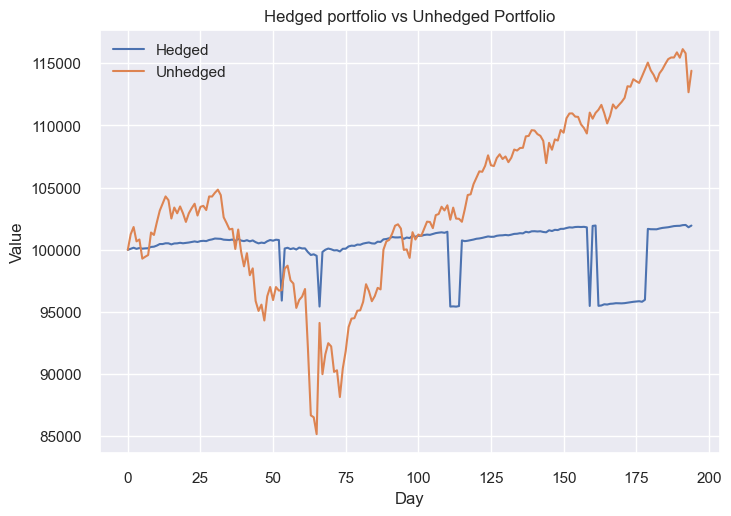

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

plt.plot([x for x in range(len(hedged_portfolio))], hedged_portfolio, label='Hedged')
plt.plot([x for x in range(len(hedged_portfolio))], unhedged_portfolio, label='Unhedged')

plt.title('Hedged portfolio vs Unhedged Portfolio')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend(loc='best')

## Analysis and Interpretation

In [228]:
unhedged_returns = pd.Series(unhedged_portfolio).pct_change().dropna() 
hedged_returns = pd.Series(hedged_portfolio).pct_change().dropna()

unhedged_mean_value, unhedged_mean_return, unhedged_vol = np.mean(unhedged_portfolio), np.mean(unhedged_returns), np.std(unhedged_returns)
hedged_mean_value, hedged_mean_return, hedged_vol = np.mean(hedged_portfolio), np.mean(hedged_returns), np.std(hedged_returns)

In [343]:
print(f'The unhedged portfolio stats are: \nmean daily value: ${round(unhedged_mean_value, 2)} \nAnnualised mean daily return: {round(unhedged_mean_return*195*100, 2)}% \nAnnualised daily volatility: {round(unhedged_vol*np.sqrt(195)*100, 2)}%')
print(f'\nThe hedged portfolio stats are: \nmean daily value: ${round(hedged_mean_value, 2)} \nAnnualised mean daily return: {round(hedged_mean_return*195*100, 2)}% \nAnnualised daily volatility: {round(hedged_vol*np.sqrt(195)*100, 2)}%')

hedge_effectiveness = 1 - (np.var(hedged_returns)/np.var(unhedged_returns))
print(f'\nThe hedge effectiveness of the strategy was {round(hedge_effectiveness*100, 2)}%, which is a direct measure of how well the hedge reduced variance')

The unhedged portfolio stats are: 
mean daily value: $103667.18 
Annualised mean daily return: 15.25% 
Annualised daily volatility: 18.65%

The hedged portfolio stats are: 
mean daily value: $100250.94 
Annualised mean daily return: 3.49% 
Annualised daily volatility: 17.56%

The hedge effectiveness of the strategy was 11.4%, which is a direct measure of how well the hedge reduced variance


In [321]:
# Take 4.5% as Risk-free rate
rf = 0.045

unhedged_sr = (unhedged_mean_return - rf/195)/unhedged_vol
hedged_sr = (hedged_mean_return - rf/195)/hedged_vol

print(f'The annualised sharpe ratio for the unhedged portfolio is {round(unhedged_sr*np.sqrt(195), 1)*100}%')
print(f'The annualised sharpe ratio for the hedged portfolio is {round(hedged_sr*np.sqrt(195), 1)*100}%')

# Drawdown
unhedged_max_drawdown = max(unhedged_portfolio) - min(unhedged_portfolio)
hedged_max_drawdown = max(hedged_portfolio) - min(hedged_portfolio)

# VaR
alpha = 0.05
unhedged_var_95 = np.percentile(unhedged_returns, 100*alpha)
hedged_var_95 = np.percentile(hedged_returns, 100*alpha)

print(f'\nFor the unhedged portfolio, the max drawdown is ${round(unhedged_max_drawdown, 2)}, while the most we stand to lose on 95% on trading days is {round(unhedged_var_95*100, 2)}%')
print(f'Similary, for the hedged portfolio, the max drawdown is ${round(hedged_max_drawdown, 2)}, while the most we stand to lose on 95% on trading days is {round(hedged_var_95*100, 2)}5')

The annualised sharpe ratio for the unhedged portfolio is 60.0%
The annualised sharpe ratio for the hedged portfolio is -10.0%

For the unhedged portfolio, the max drawdown is $30965.12, while the most we stand to lose on 95% on trading days is -1.72%
Similary, for the hedged portfolio, the max drawdown is $6569.52, while the most we stand to lose on 95% on trading days is -0.145


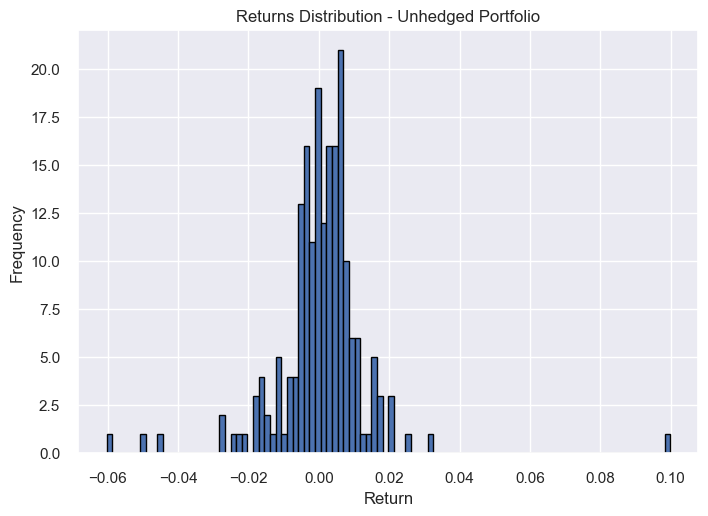

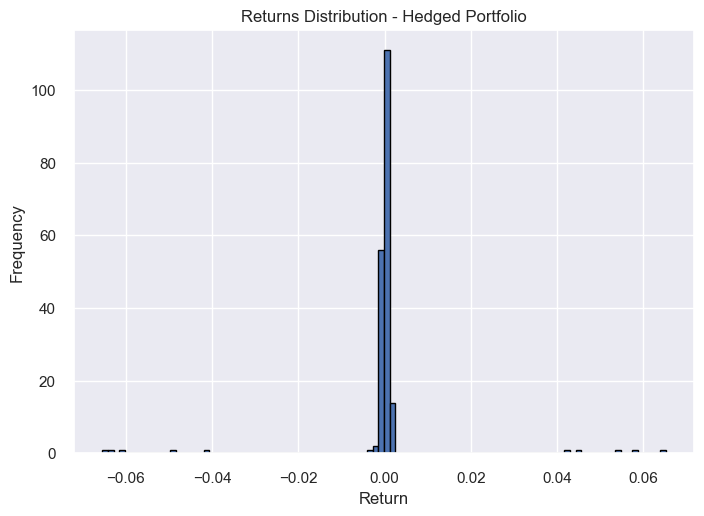

In [326]:
plt.hist(np.log(unhedged_returns + 1), bins=100, edgecolor='black')
plt.title("Returns Distribution - Unhedged Portfolio")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

plt.hist(np.log(hedged_returns + 1), bins=100, edgecolor='black')
plt.title("Returns Distribution - Hedged Portfolio")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

### The hedge did an okay job of reducing portfolio volatility (hedge effectiveness of 11.4%). This was below my expectations, and considering other costs, such taxes and transcations, were not considered, there is perhaps a lot of room for improvement in this hedging strategy.
### I suspect the reason for the unexpected inefficiency of the hedge was due to statistical insignificance of the y coefficient of my linear regression model - it had a p-value of 0.380
### On the other hand, the slope coefficient, beta, was statistically significant with a p-value of essentially 0